<!-- JPN -->
# クラスタリング

※本演習資料の二次配布・再配布はお断り致します。

<!-- ENG -->
# Clustering

※Distribution or redistribution of these exercise materials without the copyright holder's permission is not permitted.

<!-- JPN -->
　今回の演習の内容は以下の通りである。

- **1 | データセットの準備**
- **2 | 階層的クラスタリング (Hierarchical clustering)**
- **3 | <var>K</var>-meansクラスタリング (<var>K</var>-means clustering)**
- **4 | クラスタリングを用いた仮説提案の例**

　クラスタリングには多数のアルゴリズムがあるが、今回は比較的理解しやすい階層的クラスタリングと<var>K</var>-meansクラスタリングを扱う。


<!-- ENG -->
　The practice exercises this time are the following.

- **1 | Preparing a data set**
- **2 | Hierarchical clustering**
- **3 | <var>K</var>-means clustering**
- **4 | Example of a hypothesis formulation using clustering**

　There are many algorithms for clustering, but this time we will deal with hierarchical clustering and <var>K</var>-means clustering, which are relatively easy to understand.


---

<!-- JPN -->
## 1 | データセットの準備

<!-- ENG -->
## 1 | Preparing a data set

<!-- JPN -->
　今回は性質の異なる二つのデータセットを取り扱う。一つはGaussianデータセットで、中心と分散の異なる正規分布からそれぞれのクラスタが生成される。もう一つはmoonデータセットで、それぞれのクラスタが三日月型をしており、それらを組み合わせた形状をしている。

<!-- ENG -->
　This time, we will use two data sets that have different properties. One is the Gaussian data set, where each cluster is generated from a normal distribution with different centers and variances. The other is the moon data set, where each cluster has a crescent moon shape, and the shape is a combination of those.

<!-- JPN -->
　`make_blobs` はGaussianデータセットを生成する関数である。`n_samples`にデータ数のリスト、`centers`に正規分布の中心のリスト、`cluster_std`に標準偏差のリストをとる。

<!-- ENG -->
　The function `make_blobs` generates the Gaussian data set. The function takes the following arguments: a list of number of data sets for `n_samples`, a list of normal distribution centers for `centers`, and a list of standard deviations for `cluster_std`.

In [1]:
# dataset generation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

data_gaussian, labels_gaussian = make_blobs(n_samples=[100, 300], centers=[(0, 0), (5, 0)], cluster_std=[0.75, 1.25], random_state=0)

<!-- JPN -->
　moonデータセットはscikit-learnに用意されている関数を用いて生成する。

<!-- ENG -->
　The moon data set is generated using a function provided in scikit-learn.

In [2]:
from sklearn.datasets import make_moons
data_moon, labels_moon = make_moons(n_samples=300, noise=0.05, random_state=0)

<!-- JPN -->
　作成したデータセットを見てみよう。`plot_clustering`はクラスタリングした結果をプロットする関数である。

<!-- ENG -->
　Let's take a look at the data set that was created. `plot_clustering` is a function to plot the result of clustering.

In [3]:
# function for plot cluster by color
def plot_clustering(data, cluster_labels, n_clusters=2, title=None, multi_color=True):

  plt.figure(figsize=(6, 6))
  cmap = plt.get_cmap('gist_rainbow')
  for i in range(n_clusters):
    if multi_color:
      color_float = i/n_clusters
    else:
      color_float = 0
    plt.scatter(data[cluster_labels==i, 0], data[cluster_labels==i, 1],
                color=cmap(color_float))


  plt.axis('equal') # make figure square (1:1 aspect ratio)
  if title is not None:
    plt.title(title)
  plt.show()

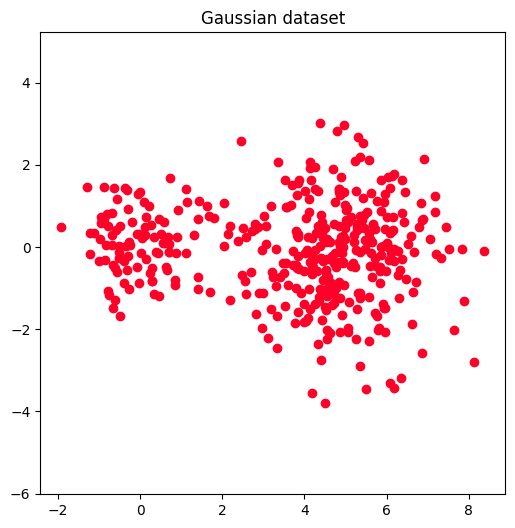

In [4]:
plot_clustering(data_gaussian, labels_gaussian, title="Gaussian dataset", multi_color=False)

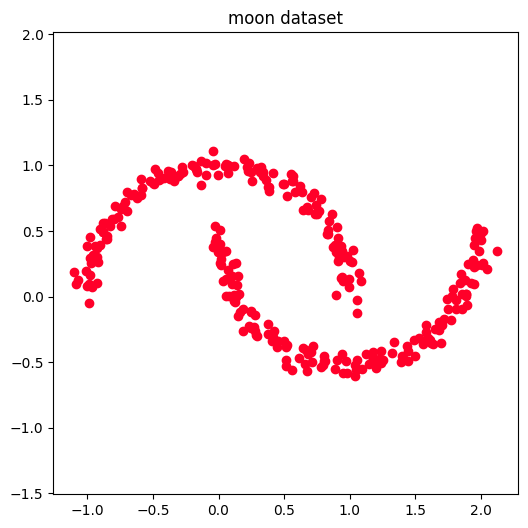

In [5]:
plot_clustering(data_moon, labels_moon, title="moon dataset", multi_color=False)

<!-- JPN -->
　これらのデータに対して以下のようなグループ分けを実現することが、クラスタリングの目的となる。

<!-- ENG -->
　The goal of clustering is to achive the following clusters for these data.

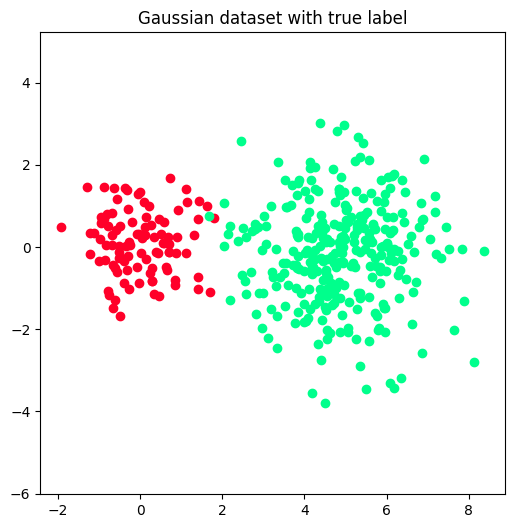

In [6]:
plot_clustering(data_gaussian, labels_gaussian, title="Gaussian dataset with true label", multi_color=True)

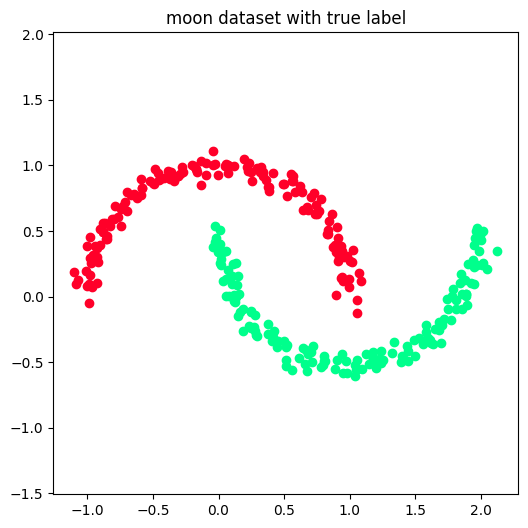

In [7]:
plot_clustering(data_moon, labels_moon, title="moon dataset with true label", multi_color=True)

<!-- JPN -->
　改めて述べておくが、今回はデータがどのクラスタに属しているかを事前に知っているが、実際のデータセットではデータがどのクラスタに属しているかが未知（教師なし）であることに注意せよ。

<!-- ENG -->
　Note that in this case, we know in advance which cluster the data belongs to, but in the actual data set, it is unknown (unsupervised) which cluster the data belongs to.

---

<!-- JPN -->
## 2 | 階層的クラスタリング (Hierarchical clustering)

<!-- ENG -->
## 2 | Hierarchical clustering

<!-- JPN -->
　クラスタリングとは、データをその特徴だけを用いて複数のグループ（クラスタ）に分割する手法のことである。同一クラスタに属するデータは互いに類似しており、異なるクラスタに属するデータは互いに類似していないことが望ましい。

　階層的クラスタリングには2種類の手法があり、**トップダウン（分割型; divisive hierarchical clustering）**と**ボトムアップ（凝集型; agglomerative hierarchical clustering）**である。
トップダウン手法では、決定木のように、すべてのデータが含まれる一つのクラスタを初期状態とし、最もよくデータを分割できる分割でクラスタを二つに分けることを繰り返してクラスタリングを行う。
ボトムアップ手法では、すべてのデータが互いに異なるクラスタに属する状態を初期状態とし、クラスタ同士の距離が最も近いペアを一つにまとめる処理を繰り返してクラスタリングを行う。

<!-- ENG -->
　Clustering is a method of dividing data into multiple groups (clusters) using only its features. Data belonging to the same cluster should be similar to each other, and data belonging to different clusters should not be similar to each other.



　There are two types of hierarchical clustering methods: **top-down (divisive hierarchical clustering)** and **bottom-up (agglomerative hierarchical clustering)**.

In the top-down method, the initial state is that the cluster contains all data as in a decision tree, and clustering is performed by repeatedly dividing the cluster into two clusters by the split that best divides the data.

In the bottom-up method, the initial state is that all data belong to different clusters from each other, and clustering is performed by repeating the process of combining the pairs with the closest distance between clusters into one.

<!-- JPN -->
　このうち、単純な実装において計算コストの面で優れているのはボトムアップ法である。直感的な理由としては、データ数を $N$ としたときトップダウン法の最初の分割の仕方はおよそ $2^N$ 通りあるのに対し、ボトムアップ法での最初のクラスタのまとめ方はおよそ $N^2$ 通りだからである。ここでは、ボトムアップ法について、実際にコードを実行してみる。

<!-- ENG -->
　Of these, the bottom-up method is superior in terms of computational cost for simple implementations. The intuitive reason is that when the number of data is $N$, there are approximately $2^N$ ways to divide the first cluster using the top-down method, while there are approximately $N^2$ ways to group the first cluster using the bottom-up method. Here, we will try to run the actual code using the bottom-up method.

<!-- JPN -->
　次のセルが実際にクラスタリングを行う部分である。クラスタ間の類似度を判定する方法が`linkage`で定義されている。`linkage`は

　`"ward", "complete", "average", "single"`

から選ぶことができる。これらの手法の詳細は講義の資料を参照せよ。なお、scikit-learnのデフォルトでは一般的によく用いられるWard法 (`"ward"`) が用いられている。

<!-- ENG -->
　The next cell is the part where the actual clustering is performed. A method to determine the similarity between clusters is defined in `linkage`. The choices for `linkage`are:

　`"ward", "complete", "average", "single"`

  Refer to the lecture materials for details of these methods. By default, scikit-learn uses the commonly used Ward's method (`"ward"`).

Number of cluster members: (282, 118)


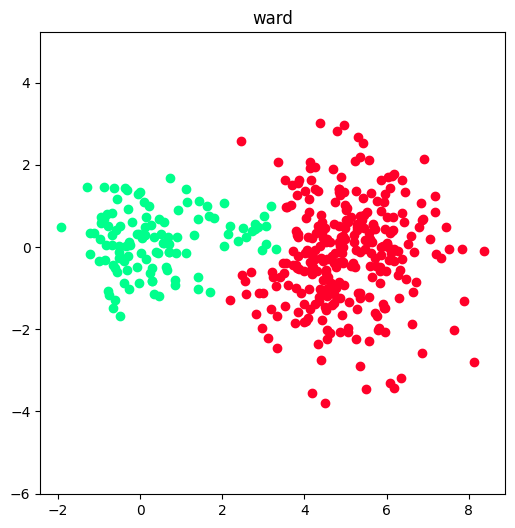

In [8]:
from sklearn.cluster import AgglomerativeClustering
from collections import Counter

n_clusters = 2
method = "ward" # CHANGE HERE

# do clustering
clustering = AgglomerativeClustering(linkage=method, n_clusters=n_clusters)
clustering.fit(data_gaussian)

# print number of cluster members
member_0 = np.count_nonzero(clustering.labels_==0)
member_1 = np.count_nonzero(clustering.labels_==1)
print(f"Number of cluster members: ({member_0}, {member_1})")

plot_clustering(data_gaussian, clustering.labels_,
                n_clusters=n_clusters, title=f"{method}")


<!-- JPN -->
　階層的クラスタリングの場合、**どのようにボトムアップでクラスタが形成されたか**を**樹形図 (dendrogram)** で確認することができる。

　樹形図を描画したい場合、 `sklearn.cluster.AgglomerativeClustering()` を用いるより、 SciPy という別のライブラリを用いた方が良いので、こちらを利用する。（**補足資料 ※1**）

<!-- ENG -->
　In the case of hierarchical clustering, a **dendrogram** can be used **to check how the clusters were formed using the bottom-up method**.

　If you want to draw a dendrogram, it is better to use another library called SciPy rather than `sklearn.cluster.AgglomerativeClustering()`, so use this one. (**Supplementary Material S1**)

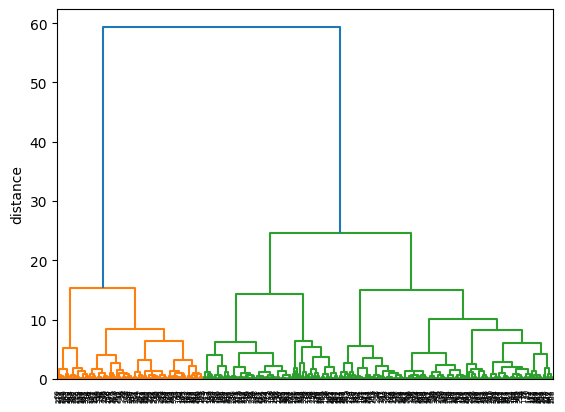

In [9]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy

Z = hierarchy.linkage(data_gaussian, method=method)
hierarchy.dendrogram(Z, color_threshold=30)
plt.ylabel("distance")
plt.show()

<!-- JPN -->
　階層的クラスタリングによって、「2つのクラスタに分ける」とは、**樹形図を2つの（より小さな）樹形図になるように横向きに**（＝あるdistanceの閾値を決めて）**はさみを入れることと同値**である。

<!-- ENG -->
　With hierarchical clustering, "dividing into two clusters" is **equivalent to scissoring a dendrogram horizontally** (i.e., by determining a particular distance threshold) **so that it becomes two (smaller) dendrograms**.

---

<!-- JPN -->
##### 課題 1
　Gaussianデータセット、moonデータセットそれぞれについて、クラスタ間の類似度を判定する手法`linkage`を変化させて実行し、それぞれについてデータをうまくクラスタリングできている手法とできていない手法を1つずつ選べ。

<!-- ENG -->
##### Exercise 1
For the Gaussian and moon data sets, vary `linkage`, the method for determining the similarity between clusters, execute, and select one method that successfully clusters the data and one method that does not.

<!-- JPN -->
<font color=orange> **このテキストセルに答案を記述せよ。** </font>

<!-- ENG -->
<font color=orange> **Write your answer in this text cell.** </font>

 For the Gaussian dataset, "Average Linkage" can successfully clusters the data as it considers the average distance, suitable for Gaussian-like data. "Single Linkage" may not work well due to sensitivity to noise.

 For the moon dataset, "Ward Linkage" can successfully clusters the non-convex data by minimizing variance within clusters. However, "Single Linkage" may not perform as effectively due to its sensitivity to outliers and noise.

---

<!-- JPN -->
##### 課題 2

課題 1 の結果が起きる理由について考察せよ。

<!-- ENG -->
##### Exercise 2

Discuss the reasons why the one is successful and the other is not, as observed in Exercise 1.


<!-- JPN -->
<font color=orange> **このテキストセルに答案を記述せよ。** </font>

<!-- ENG -->
<font color=orange> **Write your answer in this text cell.** </font>

**For Gaussian Data Set**:

**Success of Average Linkage**: Gaussian data often exhibits clusters with similar variances and densities. "Average Linkage" considers the average distance between all points in one cluster and all points in another, making it well-suited for such data, as it seeks to balance the cluster sizes and effectively captures the structure of Gaussian-like distributions.

**Failure of Single Linkage**: "Single Linkage" considers the shortest distance between any two points in different clusters, making it sensitive to outliers and noise. In the presence of noise, it tends to create long, stringy clusters, which may not accurately represent the underlying structure of the Gaussian data.

**For Moon Data Set**:

**Success of Ward Linkage**: The moon data set consists of non-convex clusters. "Ward Linkage" minimizes the variance within clusters, making it suitable for data with well-separated, non-convex structures. It's effective in capturing the compact, crescent-shaped clusters in this data.

**Failure of Single Linkage**: "Single Linkage" is sensitive to outliers and noise, and in the moon data set, it may create clusters that are overly sensitive to small irregularities and noise, leading to a less accurate representation of the underlying crescent-shaped clusters.

---

<!-- JPN -->
## 3 | <var>K</var>-meansクラスタリング (<var>K</var>-means clustering)

<!-- ENG -->
## 3 | <var>K</var>-means clustering

<!-- JPN -->
　**<var>K</var>-meansクラスタリング** は、以下のようなアルゴリズムでクラスタを決定する手法である。

1. ランダムに **$k$** 個のクラスタの中心となる点を選ぶ。
2. 各データを中心が最も近いクラスタに属させる。
3. クラスタの中心を、そのクラスタに属するデータの平均 (**mean**) に更新する。
4. 2〜3を収束するまで繰り返す。

　<var>K</var>-meansクラスタリングは、
 * 初期状態をランダムに選び、初期値に依存して結果が変化する
 * 最終的に、各データはクラスタの中心にもっとも近いクラスタに属する

といった性質をもち、クラスタ間の境界は直線もしくは（超）平面となる。

　実際に<var>K</var>-meansクラスタリングを行ってみよう。

<!-- ENG -->
　**<var>K</var>-means clustering** is a method that uses the following algorithm to determine clusters.

1. Randomly choose **$k$** points as the cluster centers.
2. Make each data item belong to the cluster whose center is closest to it.
3. Update the center of the cluster with the **mean** of the data belonging to that cluster.
4. Repeat steps 2 to 3 until convergence.

　<var>K</var>-means clustering has the following properties:
 * Randomly choose the initial state, and the result changes depending on the initial value
 * In the end, each data belongs to the cluster closest to the cluster center.

The boundaries between clusters are straight lines or (hyper)planes.

　Let's actually try <var>K</var>-means clustering in practice.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of cluster members: (111, 289)


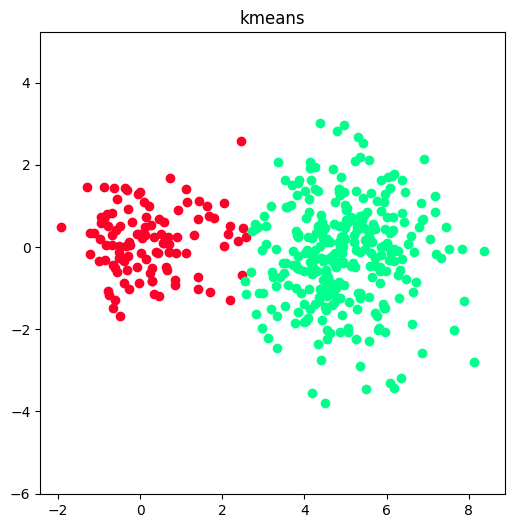

In [10]:
from sklearn.cluster import KMeans

kmeans = KMeans(random_state=0, n_clusters=2)
kmeans.fit(data_gaussian)

# print number of cluster members
member_0 = np.count_nonzero(kmeans.labels_==0)
member_1 = np.count_nonzero(kmeans.labels_==1)
print(f"Number of cluster members: ({member_0}, {member_1})")

plot_clustering(data_gaussian, kmeans.labels_, n_clusters=2, title="kmeans")
plt.show()

<!-- JPN -->
　次に、`KMeans`ライブラリを用いずに1ステップずつ<var>K</var>-meansクラスタリングを実行し、実際にどのようにクラスタリングが行われるか見てみよう。ここで★はそれぞれの中心を表しており、直線がクラスタ境界を表している。

<!-- ENG -->
　Next, let's run <var>K</var>-means clustering one step at a time without using the `KMeans` library and see how the clustering is actually performed. Here, ★ represents the center of each, and the straight line represents the cluster boundary.

In [11]:
def means_of_clusters(data, labels, n_clusters=2):
  # return means of clusters
  ret = []
  for i in range(n_clusters):
    ret.append(np.mean(data[labels==i], axis=0))
  return np.array(ret)

In [12]:
def belong_cluster(data, means):
  # return nearest cluster label for each data point
  labels = []

  # iterate by row (each data)
  for data_point in data:
    dists = []
    # iterate by row (each cluster)
    for cluster_center in means:
      dist = np.linalg.norm(data_point-cluster_center)
      dists.append(dist)

    nearest_cluster = np.argmin(dists)
    labels.append(nearest_cluster)
  return np.array(labels)

In [13]:
def plot_kmeans(data, means, cluster_labels, ax, title=None):
  # plot K-means clustering
  # only for 2 classes, because of cluster boundary implementation
  colors = ["blue", "red"]
  n_clusters = 2
  for i in range(n_clusters):
    # plot each cluster's data points
    ax.scatter(data[cluster_labels==i, 0], data[cluster_labels==i, 1],
                color=colors[i], s=16, alpha=0.7)
    # plot each cluster's mean
    ax.scatter([means[i, 0]], [means[i, 1]], marker="*",
                color="k", s=92)

  # plot cluster boundary (vertical bisector of cluster means)
  center = np.mean(means, axis=0)
  diff = means[1]-means[0]
  ortho_grad = np.array([-diff[1], diff[0]]) / np.linalg.norm(diff)
  ax.plot([center[0]-ortho_grad[0]*4, center[0]+ortho_grad[0]*4],
          [center[1]-ortho_grad[1]*4, center[1]+ortho_grad[1]*4])

  # set graph appearance
  plt.tight_layout()
  ax.set_xlim([-3, 9])
  ax.set_ylim([-6, 6])
  ax.axis('equal')
  if title is not None:
    plt.title(title)


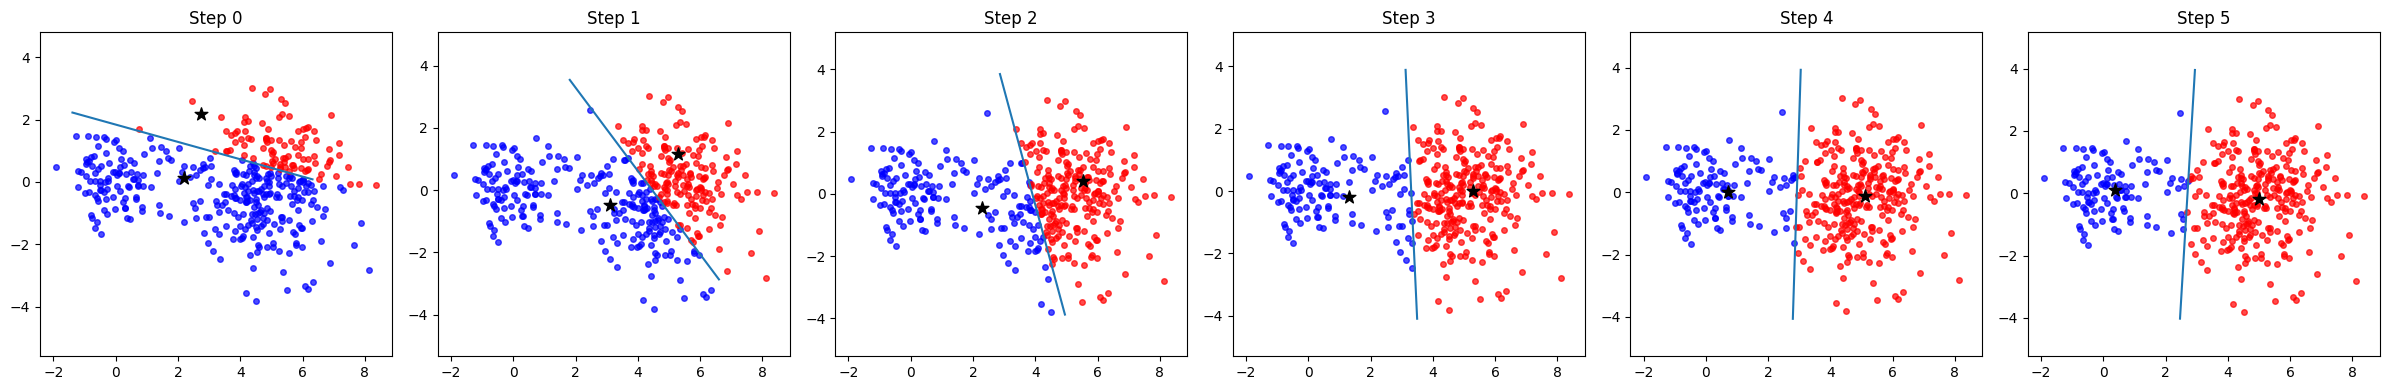

In [14]:
# clustering parameter
n_clusters = 2
initial_range = 5
n_iter = 6

fig = plt.figure(figsize=(4*n_iter, 4))

kmeans_random_seed = 2 # kmeans random seed

# randomly choose initial cluster means
np.random.seed(kmeans_random_seed)
means = np.random.rand(n_clusters, 2)*initial_range

for i in range(n_iter):
  # belong datapoints to new cluster
  kmeans_labels = belong_cluster(data_gaussian, means)

  # Add i-th figure (1-origin)
  ax = fig.add_subplot(1, n_iter, i+1)
  # Pass the figure to plot function
  plot_kmeans(data_gaussian, means, kmeans_labels, ax,
              title=f"Step {i}")

  # calculate new means
  means = means_of_clusters(data_gaussian, kmeans_labels, n_clusters)

---

<!-- JPN -->
##### 課題 3
　先に述べたように、<var>K</var>-meansクラスタリングは、ランダムに選んだ初期状態に依存して結果が変化する。

　初期値 (`kmeans_random_seed`) を変化させながら、**自作の**<var>K</var>-meansクラスタリングを実行することで、結果がどのようになるか図を示しながら考察せよ。
例えば、どのような領域がランダムな要素に影響されやすく、どのような領域はされにくいだろうか。解答には1つ以上の図を添付すること。

<!-- ENG -->
##### Exercise 3
　As mentioned earlier, the results of <var>K</var>-means clustering changes depending on the randomly chosen initial state.

　Execute **your** <var>K</var>-means clustering by changing the initial value (`kmeans_random_seed`) and discuss the results with a diagram.
For example, what areas are more likely to be affected by random elements, and what areas are less likely to be? Attach at least one figure to your answer.

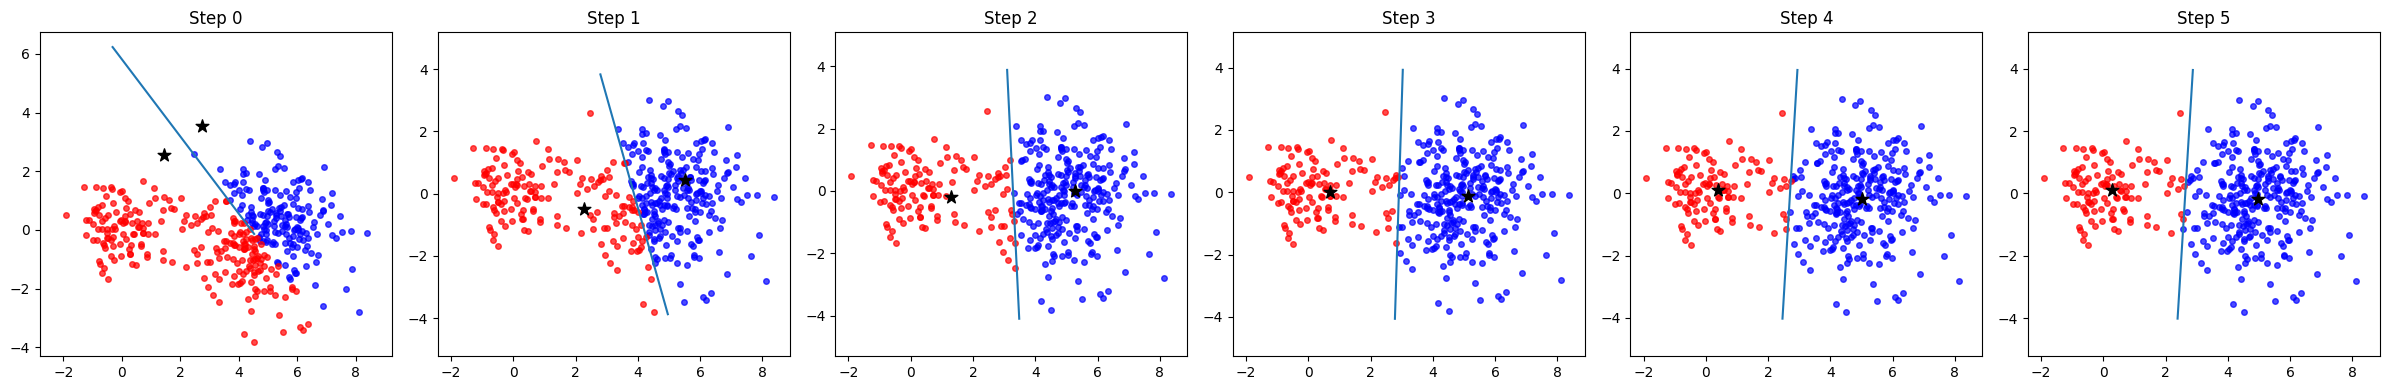

In [19]:
# CODE CELL FOR YOUR ANSWER
# ADDING CODE CELL IS ACCEPTABLE IN THIS EXERCISE
# clustering parameter
n_clusters = 2
initial_range = 5
n_iter = 6

fig = plt.figure(figsize=(4*n_iter, 4))

kmeans_random_seed = 3 # kmeans random seed

# randomly choose initial cluster means
np.random.seed(kmeans_random_seed)
means = np.random.rand(n_clusters, 2)*initial_range

for i in range(n_iter):
  # belong datapoints to new cluster
  kmeans_labels = belong_cluster(data_gaussian, means)

  # Add i-th figure (1-origin)
  ax = fig.add_subplot(1, n_iter, i+1)
  # Pass the figure to plot function
  plot_kmeans(data_gaussian, means, kmeans_labels, ax,
              title=f"Step {i}")

  # calculate new means
  means = means_of_clusters(data_gaussian, kmeans_labels, n_clusters)

<!-- JPN -->
<font color=orange> **このテキストセルに答案を記述せよ。** </font>

<!-- ENG -->
<font color=orange> **Write your answer in this text cell.** </font>

When I set the kmeans_random_seed to a value higher than 3 and notice that the clustering is failing in the end. And about the areas affected by random elements, my obsevrations are:

**Clusters Near Data Points**: Data points that are located near or in between clusters are **more likely** to change their cluster assignments with different initializations. Small shifts in initial centroid positions can cause these "border" data points to switch between clusters.

**Central Cluster Regions**: Data points located near the center of well-defined clusters are **less likely** to be affected. If the initial centroids are reasonably close to the cluster centers, the algorithm is more likely to converge to a reasonable solution.

---

<!-- JPN -->
##### 課題 4

　三日月型データ (moon) を<var>K</var>-meansクラスタリング（クラスタ数は2とする）でクラスタリングするとどうなるだろうか。
 * **実行前に結果を予想し**、いくつかの初期値 (`kmeans_random_seed`) について自作<var>K</var>-meansクラスタリングを実行した結果と比較して考察せよ。また、
 * なぜそのような結果になるのかを記述せよ。

　なお、ここではデータのスケールを揃えるため三日月型データセットを以下のようにすると良い。

<!-- ENG -->
##### Exercise 4

　What happens if we cluster the moon data with <var>K</var>-means clustering (the number of clusters is 2)?
 * **Predict the results prior to execution**, then compare and discuss the results with the actual execution results with your <var>K</var>-means clustering for some initial value (`kmeans_random_seed`), and;  
 * Describe why that happened

　In order to keep the scale of the data the same, the moon data set should be as follows.

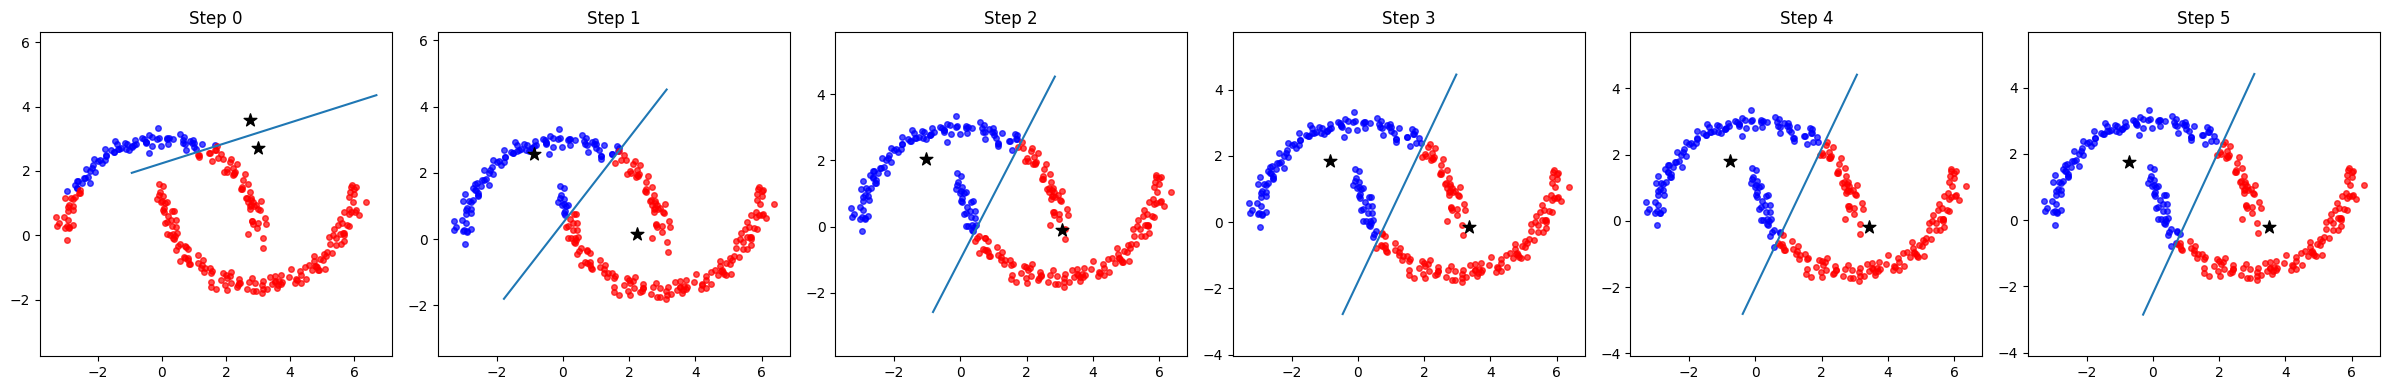

In [46]:
# CODE CELL FOR YOUR ANSWER
# ADDING CODE CELL IS ACCEPTABLE IN THIS EXERCISE
kmeans_data_moon = data_moon * 3

n_clusters = 2
initial_range = 5
n_iter = 6

fig = plt.figure(figsize=(4*n_iter, 4))

kmeans_random_seed = 0 # kmeans random seed

# randomly choose initial cluster means
np.random.seed(kmeans_random_seed)
means = np.random.rand(n_clusters, 2)*initial_range

for i in range(n_iter):
  # belong datapoints to new cluster
  kmeans_labels = belong_cluster(kmeans_data_moon, means)

  # Add i-th figure (1-origin)
  ax = fig.add_subplot(1, n_iter, i+1)
  # Pass the figure to plot function
  plot_kmeans(kmeans_data_moon, means, kmeans_labels, ax,
              title=f"Step {i}")

  # calculate new means
  means = means_of_clusters(kmeans_data_moon, kmeans_labels, n_clusters)

<!-- JPN -->
<font color=orange> **このテキストセルに答案を記述せよ。** </font>

<!-- ENG -->
<font color=orange> **Write your answer in this text cell.** </font>

**Prediction:**

The moon-shaped dataset has two distinct "moon" shapes, which means it naturally forms two clusters.

Scaling the data by a factor of 3 might spread out the points in the dataset and make the clusters less compact.

**Actual Execution Results:**

Scaling the moon data by a factor of 3 means that the distance between data points is effectively increased that affect the clustering results because the algorithm is based on distances between data points.

The moon data has a non-convex shape, and <var>K</var>-means is designed for convex clusters. It may not perform optimally on such data.


---

<!-- JPN -->
##### 課題 5
　<var>K</var>-meansクラスタリングはクラスタ数を事前に入力する必要がある。<var>K</var>-meansクラスタリングに限らず、クラスタリングではいくつのクラスタに分けるかを人間が決定しなければならない場合が多く存在する。
**クラスタ数を客観的に決めるための方法について、考えて述べよ**。

<!-- ENG -->
##### Exercise 5
　<var>K</var>-means clustering requires the number of clusters to be entered in advance. Not only limited to <var>K</var>-means clustering, but there are many cases in clustering where you have to specify how many clusters to divide into.
**Discuss and describe a method for objectively determining the number of clusters.**

<!-- JPN -->
<font color=orange> **このテキストセルに答案を記述せよ。** </font>

<!-- ENG -->
<font color=orange> **Write your answer in this text cell.** </font>

After some investigations, I find a method called **Silhouette Score** which quantifies the quality of clusters. It can measure how similar an object is to its cluster (cohesion) compared to other clusters (separation). Calculate the Silhouette Score for a range of cluster numbers and choose the number that maximizes this score. A higher Silhouette Score suggests better-defined clusters.

---

<!-- JPN -->
##### 課題 6（発展）
　課題 5 で考えたクラスタ数を客観的に決めるための方法をGaussianデータセット、moonデータセット両方に適用し、機能したかどうか、それは何故か、考察せよ。

<!-- ENG -->
##### Exercise 6 (Advanced)
　Apply the method for objectively determining the number of clusters considered in Exercise 5. to both the Gaussian and moon data sets, and discuss whether it worked and why.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Optimal number of clusters: 2


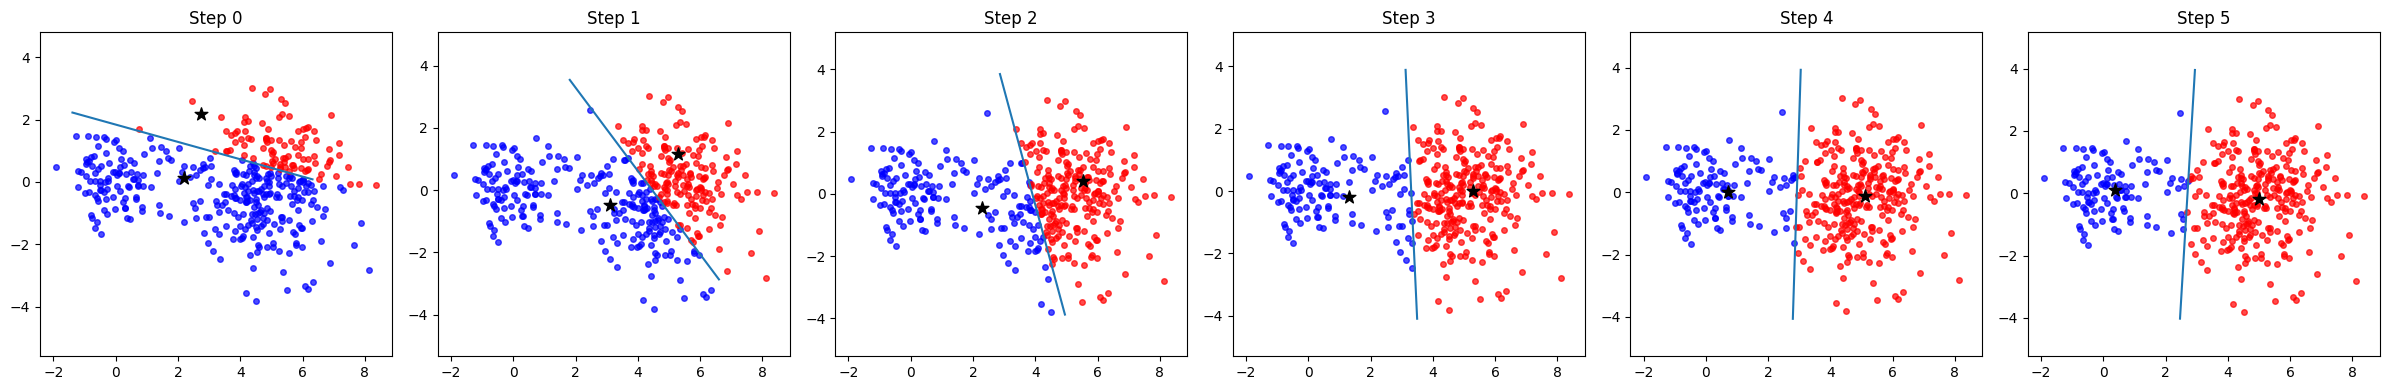

In [60]:
# CODE CELL FOR YOUR ANSWER
# ADDING CODE CELL IS ACCEPTABLE IN THIS EXERCISE
from sklearn.metrics import silhouette_score

initial_range = 5
n_iter = 6

fig = plt.figure(figsize=(4*n_iter, 4))

kmeans_random_seed = 2 # kmeans random seed

# Define a range of cluster numbers to evaluate

best_score = -1
best_num_clusters = 2  # A sensible default if no good clusters are found

cluster_range = range(2, 11)

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(data_gaussian)
    silhouette_avg = silhouette_score(data_gaussian, labels)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_num_clusters = num_clusters

print("Optimal number of clusters:", best_num_clusters)
n_clusters = best_num_clusters

# randomly choose initial cluster means
np.random.seed(kmeans_random_seed)
means = np.random.rand(n_clusters, 2)*initial_range

for i in range(n_iter):
  # belong datapoints to new cluster
  kmeans_labels = belong_cluster(data_gaussian, means)

  # Add i-th figure (1-origin)
  ax = fig.add_subplot(1, n_iter, i+1)
  # Pass the figure to plot function
  plot_kmeans(data_gaussian, means, kmeans_labels, ax,
              title=f"Step {i}")

  # calculate new means
  means = means_of_clusters(data_gaussian, kmeans_labels, n_clusters)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

Optimal number of clusters: 8


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


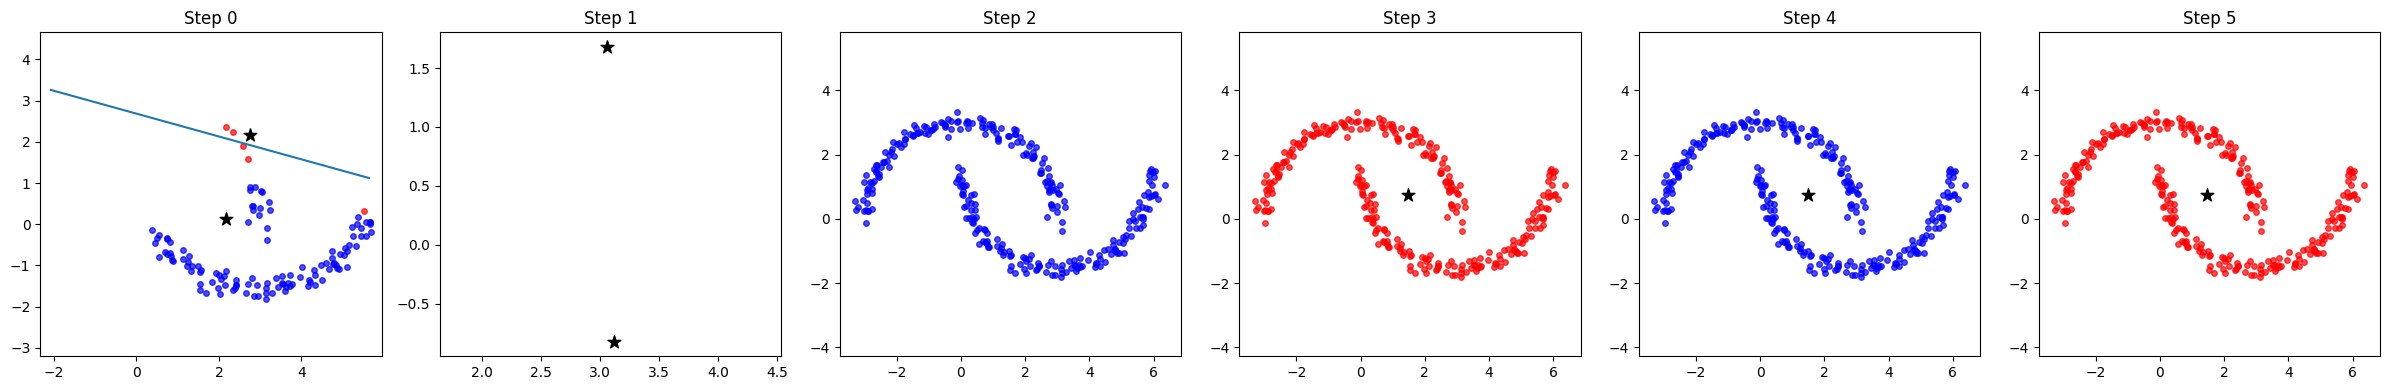

In [59]:
from sklearn.metrics import silhouette_score

kmeans_data_moon = data_moon * 3

initial_range = 5
n_iter = 6

fig = plt.figure(figsize=(4*n_iter, 4))

kmeans_random_seed = 2 # kmeans random seed

# Define a range of cluster numbers to evaluate

best_score = -1
best_num_clusters = 2  # A sensible default if no good clusters are found

cluster_range = range(2, 11)

for num_clusters in cluster_range:
    kmeans = KMeans(n_clusters=num_clusters)
    labels = kmeans.fit_predict(kmeans_data_moon)
    silhouette_avg = silhouette_score(kmeans_data_moon, labels)

    if silhouette_avg > best_score:
        best_score = silhouette_avg
        best_num_clusters = num_clusters

print("Optimal number of clusters:", best_num_clusters)
n_clusters = best_num_clusters

# randomly choose initial cluster means
np.random.seed(kmeans_random_seed)
means = np.random.rand(n_clusters, 2)*initial_range

for i in range(n_iter):
  # belong datapoints to new cluster
  kmeans_labels = belong_cluster(kmeans_data_moon, means)

  # Add i-th figure (1-origin)
  ax = fig.add_subplot(1, n_iter, i+1)
  # Pass the figure to plot function
  plot_kmeans(kmeans_data_moon, means, kmeans_labels, ax,
              title=f"Step {i}")

  # calculate new means
  means = means_of_clusters(kmeans_data_moon, kmeans_labels, n_clusters)

<!-- JPN -->
<font color=orange> **このテキストセルに答案を記述せよ。** </font>

<!-- ENG -->
<font color=orange> **Write your answer in this text cell.** </font>

From the results after I applied the **Silhouette Score** on two datasets, we can see and find that, for the Gaussian Data Set, the method work well in identifying the optimal number of clusters, while for the Moon Data Set, it was failed to indicate the appropriate number of clusters and can not capture the complex crescent shapes which may due to the limitations of K-means for non-convex data.

---

<!-- JPN -->
## 4 | クラスタリングを用いた仮説提案の例

<!-- ENG -->
## 4 | Example of a hypothesis formulation using clustering

<!-- JPN -->
　クラスタリングなどの教師なし学習では、答え（〇/×、あるいは予測したい数値）が存在しないことが多々あり、このような場合には**解析結果から新しい仮説を立てることが重要になる**。

<!-- ENG -->
　In unsupervised learning such as clustering, the answer (YES/NO or the number you want to predict) often does not exist, and in such cases **it is important to formulate a new hypothesis from the analysis results**.

<!-- JPN -->
　ここでは、Kaggleに公開されている通販の顧客データセット（おそらく人工データ、1次ソースはUdemyの資料のようだ）に対して<var>K</var>-meansクラスタリングを実施、どのような結果が得られるのかを確かめてみる。

<!-- ENG -->
　Here, we will perform <var>K</var>-means clustering on the mail order customer data set available on Kaggle (likely artificial data, primary source seems to be Udemy's material) and see what kind of results we get.

https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python


<!-- JPN -->
　この結果から、どういう層に売り込みをかければいいのか、を考えようとしている、と想像してほしい。

<!-- ENG -->
　Imagine that you are trying to figure out what kind of audience you should market to based on these results.

<!-- JPN -->
　さて、今回は「年収」「購入スコア（購買履歴などから計算されたスコア）」について<var>K</var>-meansクラスタリングを行ってみる。

<!-- ENG -->
　Now, let's try <var>K</var>-means clustering for "annual income" and "spending score (score calculated from purchase history, etc.)".

In [61]:
# Preparing a data set
import pandas as pd
import requests
import io

# Get data sets from the Internet
url = "https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv"
download = requests.get(url).content
csv_string = io.StringIO(download.decode('utf-8'))
data_df = pd.read_csv(csv_string)
data_df = data_df.drop("CustomerID", axis=1) # Delete Customer ID column
data_df = data_df.drop("Genre", axis=1)      # Remove Genre column (gender) as it is too cumbersome to process

In [62]:
print(data_df.head())
print("------------")
print(data_df.describe())

   Age  Annual Income (k$)  Spending Score (1-100)
0   19                  15                      39
1   21                  15                      81
2   20                  16                       6
3   23                  16                      77
4   31                  17                      40
------------
              Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000          200.000000              200.000000
mean    38.850000           60.560000               50.200000
std     13.969007           26.264721               25.823522
min     18.000000           15.000000                1.000000
25%     28.750000           41.500000               34.750000
50%     36.000000           61.500000               50.000000
75%     49.000000           78.000000               73.000000
max     70.000000          137.000000               99.000000


<!-- JPN -->
　ここから年収と購買スコアを取得して<var>K</var>-meansクラスタリングを行うのだが、この2種類の値は異なる分散を持つ。**<var>K</var>-meansクラスタリングはデータ間のユークリッド距離を通常用いる**ため、より分散が大きい特徴量が重要であるかのように取り扱われてしまう。

　これを避けるためには、**<var>K</var>-meansクラスタリングを行う前に標準化**を行えばよい。

<!-- ENG -->
　From here, we get the annual income and spending score to perform <var>K</var>-means clustering, and these two types of values have different variances. Since **<var>K</var>-means clustering usually uses the Euclidean distance between data**, features with higher variance are treated as if they are more important.



　To avoid this, you should carry out **standardization before implementing <var>K</var>-means clustering**.

In [63]:
from sklearn.preprocessing import StandardScaler

X = data_df[["Annual Income (k$)", "Spending Score (1-100)"]].values
X_std = StandardScaler().fit_transform(X)

<!-- JPN -->
　では、<var>K</var>-meansクラスタリングを実施してみよう。

<!-- ENG -->
　Now, let's try implementing <var>K</var>-means clustering.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


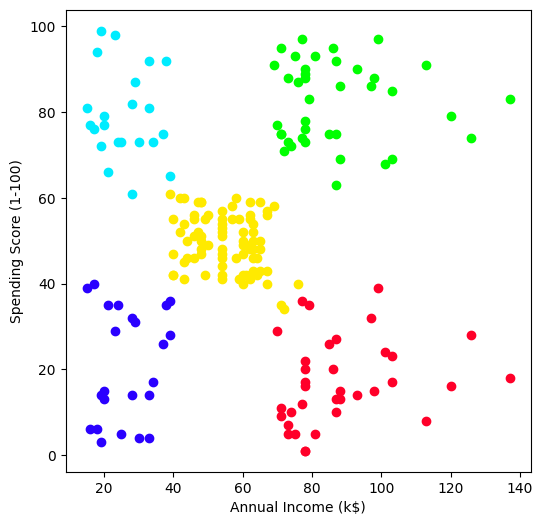

In [64]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

kmeans_random_seed = 0
n_clusters = 5
kmeans = KMeans(random_state=kmeans_random_seed, n_clusters=n_clusters)
kmeans.fit(X_std)


# Figure drawing
plt.figure(figsize=(6, 6))
cmap = plt.get_cmap('gist_rainbow')
for i in range(n_clusters):
    plt.scatter(data_df.loc[kmeans.labels_==i, "Annual Income (k$)"],
                data_df.loc[kmeans.labels_==i, "Spending Score (1-100)"],
                color=cmap(i/n_clusters))

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.show()

<!-- JPN -->
　なるほど、かなり明確に5つのクラスタに分割できるようである。それぞれのグループの各要素の平均値などはどうなっているだろうか。

<!-- ENG -->
　Well, it seems that it can be divided into five clusters quite clearly. What is the mean value etc. of each element for each group?

In [65]:
for i in range(n_clusters):
  print("cluster", i)
  print(data_df[kmeans.labels_==i].mean())
  print("----------------------------------")

cluster 0
Age                       41.114286
Annual Income (k$)        88.200000
Spending Score (1-100)    17.114286
dtype: float64
----------------------------------
cluster 1
Age                       42.716049
Annual Income (k$)        55.296296
Spending Score (1-100)    49.518519
dtype: float64
----------------------------------
cluster 2
Age                       32.692308
Annual Income (k$)        86.538462
Spending Score (1-100)    82.128205
dtype: float64
----------------------------------
cluster 3
Age                       25.272727
Annual Income (k$)        25.727273
Spending Score (1-100)    79.363636
dtype: float64
----------------------------------
cluster 4
Age                       45.217391
Annual Income (k$)        26.304348
Spending Score (1-100)    20.913043
dtype: float64
----------------------------------


<!-- JPN -->
　この結果から、例えば以下のようなことがわかる。

- 購買スコアも年収も高い「理想的な顧客」のクラスタの平均年齢が若いことから、それらの顧客を離さない戦略が重要であるかもしれない。
- 一方で、年収が高いにも関わらず購買スコアが低い「潜在能力のある顧客」のクラスタの平均年齢は高いため、新規顧客の獲得は中高年層に対して行うべきかもしれない。

<!-- ENG -->
　The results show, for example, the following.

- Since the average age of the cluster of "ideal customers" with high spending scores and annual income is young, strategies to keep those customers engaged may be important.

- On the other hand, the average age of the cluster of "potential customers" with low spending scores despite their high annual income is high, so perhaps new customer acquisition should be done for middle-aged and older people.

<!-- JPN -->
　このような解析を行うことで、 **人間が目視して発見するよりも簡単に、かつ高速に、様々な仮説を立てる**ことができるようになる。

　ただし、利用する特徴量、あるいはクラスタ数は人間の主観が入る。データ数が少ない時は人間の感覚の介入が顕著になる。**あくまで仮説であり、絶対の事実ではない**ことを意識して、新しい顧客（＝データ）が来たときに、この仮説が成り立っているか、新しい戦略を打った時に想定通りの変化が起きているかどうかを注視することが重要である。

　この演習を通して述べることだが、 **「データは愛でるくらい見なければならない」** ことを忘れてはならないのである。

<!-- ENG -->
　This kind of analysis will allow us to **formulate various hypotheses more easily and faster than a human can discover by sight**.

　However, the number of features or clusters to be used is subjective. When the number of data is small, the intervention of human perception becomes more pronounced. It is important to be aware that **this is only a hypothesis and not an absolute fact**, and to keep an eye on whether this hypothesis holds true when new customers (i.e., data) arrive, and whether the changes occur as expected when new strategies are implemented.

　As we want to emphasize throughout this practice exercise, it is important to remember that **"you have to look at the data like you love doing it"**.

------

<!-- JPN -->
# 補足資料

<!-- ENG -->
# Supplementary Material

<!-- JPN -->
## ※1 | `sklearn.cluster.AgglomerativeClustering()` と `scipy.cluster.hierarchy()` の関係

　クラスタリングを行う場合には scikit-learn を、樹形図 (dendrogram) を描画する場合には SciPy を利用した。通常、異なるライブラリを利用すると、ライブラリの実装方法によって結果が多少異なるはずだ。しかし、`sklearn.cluster.AgglomerativeClustering()` は内部で `scipy.cluster.hierarchy()` が使われており、出力作成にあたって構成されるクラスタリングや、クラスタリング手法を選択するキーワード（`ward`や`complete`など）は完全に同一のものになっている。

　以上の理由から、2つのライブラリを横断的に利用してクラスタリングと樹形図の描画を行ったが、scikit-learnのホームページを見ると、 `AgglomerativeClustering()` から樹形図を作る方法も示されている。難解なので授業では利用しなかったが、参照すると、 `Z` がどういうデータなのか、それをどのように作成するのかなど、より深い理解につながるかもしれない。

<!-- ENG -->
## S1 | Relationship between `sklearn.cluster.AgglomerativeClustering() ` and ` scipy.cluster.hierarchy()`

　scikit-learn was used for clustering, and SciPy was used for drawing dendrograms. Usually, if you use different libraries, the results should be somewhat different depending on how the library is implemented. However, `sklearn.cluster.AgglomerativeClustering()` uses `scipy.cluster.hierarchy()` internally, and the clustering which is consisted for output creation and keywords for selecting the clustering method (such as `ward` and `complete`) are completely identical.

　For these reasons, the two libraries were used across the board for clustering and drawing dendrograms, but the scikit-learn homepage also shows how to create dendrograms from `AgglomerativeClustering()`. This method was not used in the lecture because it is difficult to understand, but referring to it may lead to a deeper understanding of what kind of data `Z` is and how to create it.


https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html